# air quality (lightGBM regressor)
* Notebook: 
* data source: https://aqicn.org/data-platform/register/

---
* author:  [Prasert Kanawattanachai](prasert.k@chula.ac.th)
* YouTube: https://www.youtube.com/prasertcbs
* github: https://github.com/prasertcbs/
* [Chulalongkorn Business School](https://www.cbs.chula.ac.th/en/)
---

In [1]:
import sys
import math
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(f'Python  version: {sys.version}')
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

Python  version: 3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
pandas  version: 1.2.3
numpy   version: 1.19.2
seaborn version: 0.11.1


## read and preprocess data

In [4]:
data_url='https://github.com/prasertcbs/basic-dataset/raw/master/bangkok-air-quality.csv'
data=pd.read_csv(data_url, parse_dates=['date'], na_values=[' '], skipinitialspace=True)
data

,date,pm25,pm10,o3,no2,so2,co
0,2021-03-01,93.0,30.0,8.0,6.0,1.0,NaN
1,2021-03-02,68.0,27.0,7.0,5.0,1.0,NaN
2,2021-03-03,58.0,37.0,13.0,9.0,1.0,NaN
3,2021-03-04,74.0,35.0,13.0,6.0,NaN,NaN
4,2021-03-05,72.0,38.0,15.0,6.0,1.0,NaN
...,...,...,...,...,...,...,...
2619,2015-03-15,NaN,NaN,23.0,13.0,3.0,9.0
2620,2014-11-30,NaN,NaN,40.0,36.0,4.0,11.0
2621,2013-12-31,NaN,NaN,68.0,33.0,3.0,7.0
2622,2014-01-26,NaN,NaN,54.0,53.0,6.0,18.0


In [5]:
data.columns

Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co'], dtype='object')

In [6]:
data.columns=data.columns.str.strip()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2624 non-null   datetime64[ns]
 1   pm25    1680 non-null   float64       
 2   pm10    2609 non-null   float64       
 3   o3      2610 non-null   float64       
 4   no2     2611 non-null   float64       
 5   so2     1877 non-null   float64       
 6   co      963 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 143.6 KB


In [8]:
data=data.sort_values('date').reset_index(drop=True).copy()
data

,date,pm25,pm10,o3,no2,so2,co
0,2013-12-31,NaN,NaN,68.0,33.0,3.0,7.0
1,2014-01-01,NaN,84.0,90.0,48.0,5.0,16.0
2,2014-01-02,NaN,84.0,119.0,63.0,7.0,14.0
3,2014-01-03,NaN,103.0,95.0,57.0,7.0,13.0
4,2014-01-04,NaN,101.0,52.0,34.0,1.0,NaN
...,...,...,...,...,...,...,...
2619,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN
2620,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN
2621,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN
2622,2021-03-13,96.0,32.0,9.0,4.0,1.0,NaN


In [9]:
y_col='pm25'

In [10]:
data.dropna(subset=[y_col], inplace=True)
data=data.reset_index(drop=True)
data

,date,pm25,pm10,o3,no2,so2,co
0,2016-07-30,61.0,19.0,17.0,15.0,8.0,6.0
1,2016-07-31,68.0,24.0,25.0,13.0,7.0,6.0
2,2016-08-01,60.0,20.0,26.0,14.0,2.0,6.0
3,2016-08-02,68.0,25.0,21.0,14.0,7.0,6.0
4,2016-08-03,70.0,26.0,23.0,16.0,2.0,6.0
...,...,...,...,...,...,...,...
1675,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN
1676,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN
1677,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN
1678,2021-03-13,96.0,32.0,9.0,4.0,1.0,NaN


In [11]:
def date_parts(data, date_colname='date'):
    '''create year, month, day, dayname columns'''
    data['year']=data['date'].dt.year
    data['month']=data['date'].dt.month
    data['day']=data['date'].dt.day
    data['day_name']=data['date'].dt.day_name()
    data['day_name']=pd.Categorical(data['day_name'], 
               categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], ordered=True)

In [12]:
date_parts(data)

In [13]:
data

,date,pm25,pm10,o3,no2,so2,co,year,month,day,day_name
0,2016-07-30,61.0,19.0,17.0,15.0,8.0,6.0,2016,7,30,Saturday
1,2016-07-31,68.0,24.0,25.0,13.0,7.0,6.0,2016,7,31,Sunday
2,2016-08-01,60.0,20.0,26.0,14.0,2.0,6.0,2016,8,1,Monday
3,2016-08-02,68.0,25.0,21.0,14.0,7.0,6.0,2016,8,2,Tuesday
4,2016-08-03,70.0,26.0,23.0,16.0,2.0,6.0,2016,8,3,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
1675,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN,2021,3,10,Wednesday
1676,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN,2021,3,11,Thursday
1677,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN,2021,3,12,Friday
1678,2021-03-13,96.0,32.0,9.0,4.0,1.0,NaN,2021,3,13,Saturday


In [14]:
data.columns

Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'year', 'month',
       'day', 'day_name'],
      dtype='object')

In [15]:
df=data[['date', 'year', 'month', 'day', 'day_name', y_col]]
df

,date,year,month,day,day_name,pm25
0,2016-07-30,2016,7,30,Saturday,61.0
1,2016-07-31,2016,7,31,Sunday,68.0
2,2016-08-01,2016,8,1,Monday,60.0
3,2016-08-02,2016,8,2,Tuesday,68.0
4,2016-08-03,2016,8,3,Wednesday,70.0
...,...,...,...,...,...,...
1675,2021-03-10,2021,3,10,Wednesday,98.0
1676,2021-03-11,2021,3,11,Thursday,111.0
1677,2021-03-12,2021,3,12,Friday,101.0
1678,2021-03-13,2021,3,13,Saturday,96.0


In [16]:
df=df.set_index('date')
df

,year,month,day,day_name,pm25
date,,,,,
2016-07-30,2016,7,30,Saturday,61.0
2016-07-31,2016,7,31,Sunday,68.0
2016-08-01,2016,8,1,Monday,60.0
2016-08-02,2016,8,2,Tuesday,68.0
2016-08-03,2016,8,3,Wednesday,70.0
...,...,...,...,...,...
2021-03-10,2021,3,10,Wednesday,98.0
2021-03-11,2021,3,11,Thursday,111.0
2021-03-12,2021,3,12,Friday,101.0


## lightgbm regressor
* `lightGBM` doc: https://lightgbm.readthedocs.io/en/latest/
* `LGBMRegressor`: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html


how to install lightgbm
* pip: `pip install -U lightgbm`
* conda: `conda install lightgbm`

In [17]:
feature_cols=[
    'year', 'month', 
    'day', 
    'day_name'
]
y_col='pm25'
X=df[feature_cols]
y=df[y_col]

In [18]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.10, 
#                                                     random_state=1)

In [19]:
split_at=1400
X_train, X_test, y_train, y_test=X[:split_at], X[split_at:], y[:split_at], y[split_at:]

In [20]:
import lightgbm as lgb
print(f'lightgbm version = {lgb.__version__}')

lightgbm version = 3.1.1


In [21]:
reg = lgb.LGBMRegressor()

In [22]:
reg.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [23]:
params={'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
}
# reg = lgb.LGBMRegressor()
# reg = lgb.LGBMRegressor(**params)

In [24]:
fit_params={'early_stopping_rounds':200, 
            'eval_set': [(X_test, y_test)],
            'verbose': 10
           }
reg.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 200 rounds
[10]	valid_0's l2: 595.372
[20]	valid_0's l2: 480.014
[30]	valid_0's l2: 445.974
[40]	valid_0's l2: 441.924
[50]	valid_0's l2: 428.934
[60]	valid_0's l2: 433.142
[70]	valid_0's l2: 427.028
[80]	valid_0's l2: 430.409
[90]	valid_0's l2: 439.008
[100]	valid_0's l2: 438.816
Did not meet early stopping. Best iteration is:
[53]	valid_0's l2: 424.451


LGBMRegressor()

In [25]:
# reg.__dict__

In [26]:
reg.score(X_train, y_train)

0.7295911991286056

In [27]:
reg.score(X_test, y_test)

0.6505958421504906

In [28]:
reg.predict(X_test[:5])

array([53.27422258, 54.36515107, 54.39295735, 55.55244506, 53.82166848])

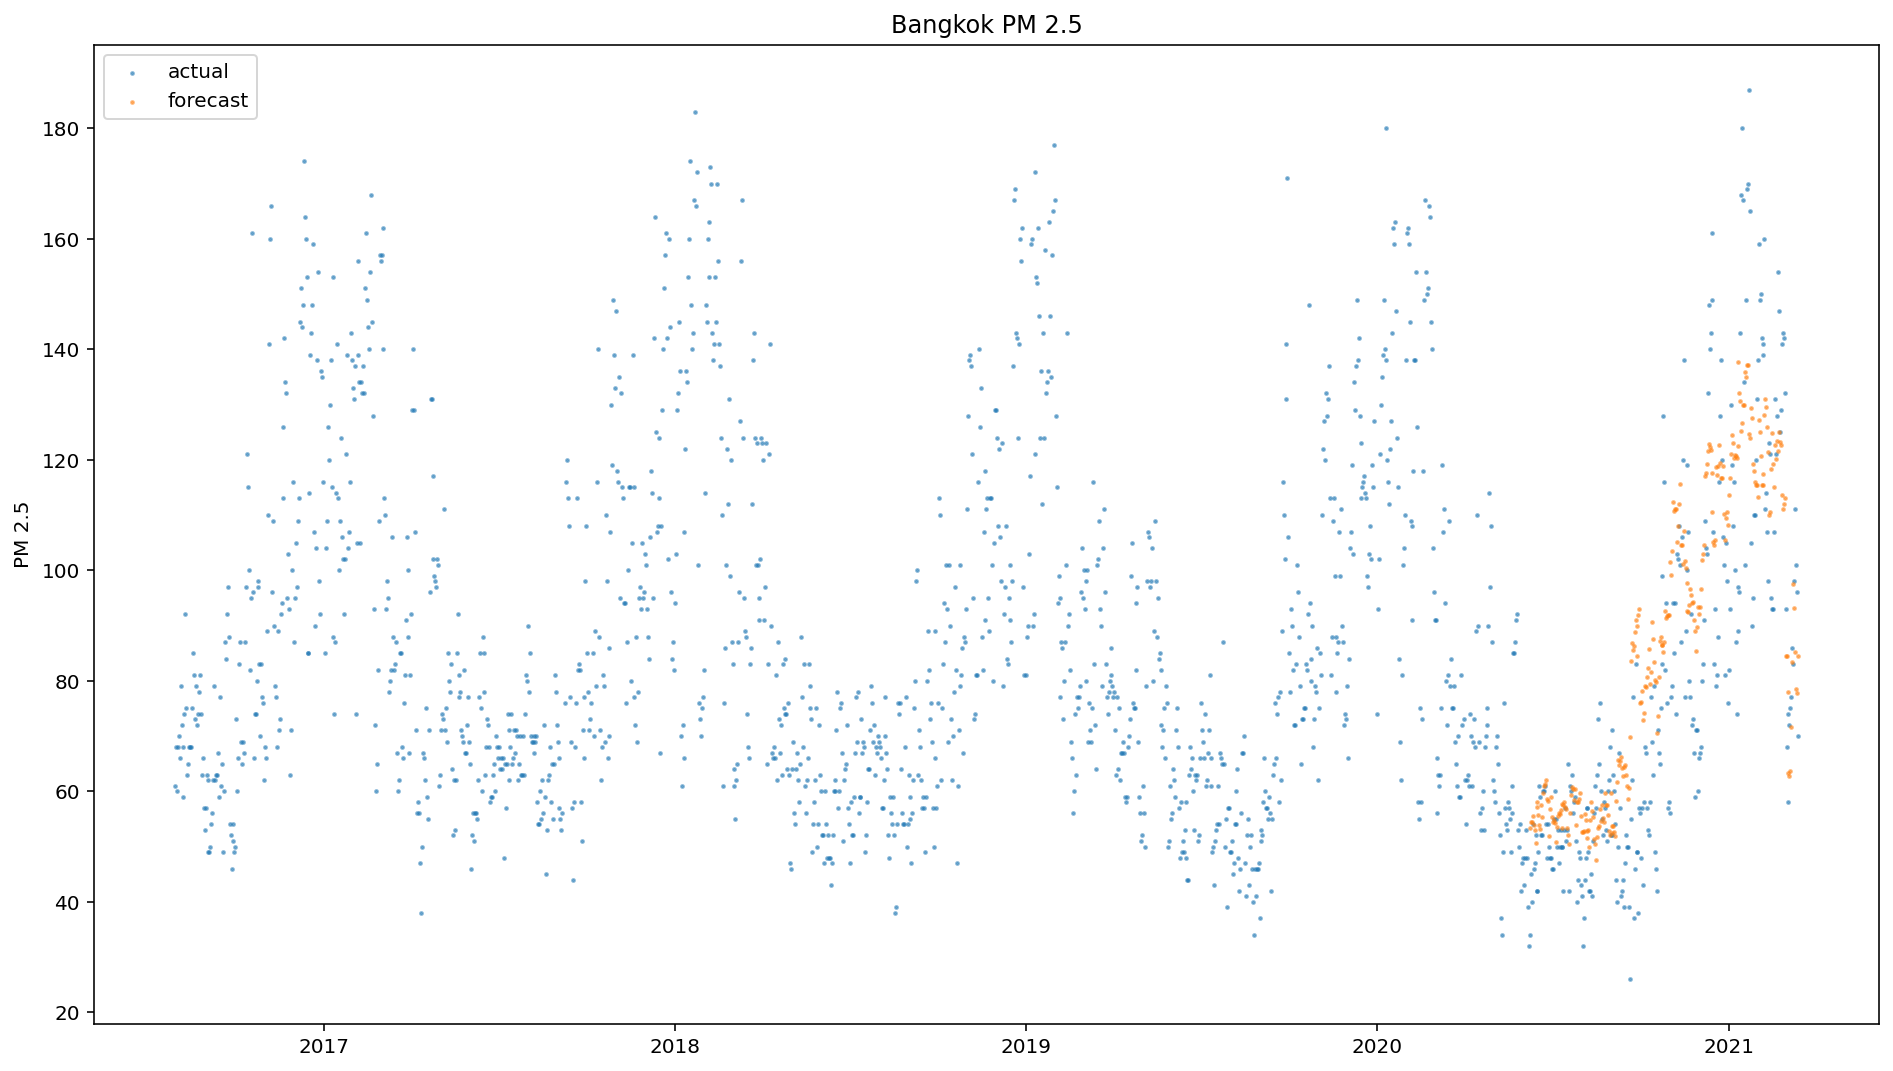

In [29]:
plt.figure(figsize=(16, 9))
plt.scatter(df.index, df[y_col], alpha=.5, s=2, label='actual')
plt.scatter(X_test.index, reg.predict(X_test), alpha=.5, s=2, label='forecast')
plt.ylabel('PM 2.5')
plt.title('Bangkok PM 2.5')
plt.legend();

In [30]:
df

,year,month,day,day_name,pm25
date,,,,,
2016-07-30,2016,7,30,Saturday,61.0
2016-07-31,2016,7,31,Sunday,68.0
2016-08-01,2016,8,1,Monday,60.0
2016-08-02,2016,8,2,Tuesday,68.0
2016-08-03,2016,8,3,Wednesday,70.0
...,...,...,...,...,...
2021-03-10,2021,3,10,Wednesday,98.0
2021-03-11,2021,3,11,Thursday,111.0
2021-03-12,2021,3,12,Friday,101.0


## SHAP
* document: https://github.com/slundberg/shap

In [31]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [32]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

In [33]:
explainer.__dict__

{'model': <shap.explainers._tree.TreeEnsemble at 0x1cfa0914b88>,
 'output_names': None,
 'feature_names': None,
 'masker': None,
 'link': CPUDispatcher(<function identity at 0x000001CFA4EAACA8>),
 'data': None,
 'data_missing': None,
 'feature_perturbation': 'tree_path_dependent',
 'expected_value': 87.2921428544752,
 'model_output': 'raw'}

In [34]:
# shap values of each case
dshap=pd.DataFrame(shap_values, columns=feature_cols)
dshap

,year,month,day,day_name
0,0.433135,-21.186345,-3.200536,-0.930889
1,0.723131,-22.549168,-2.200711,-1.685491
2,1.872776,-24.653867,-3.852356,-0.927087
3,1.893634,-23.933147,-4.261921,0.529303
4,2.042577,-24.349573,-3.200153,1.063245
...,...,...,...,...
1395,-5.370927,-27.112470,-3.384209,0.827685
1396,-6.075502,-26.732261,-3.364423,-0.143743
1397,-6.290662,-27.054390,-2.974962,-0.528898
1398,-7.510049,-27.468367,-1.860349,-0.512638


In [35]:
X_train[:5]

,year,month,day,day_name
date,,,,
2016-07-30,2016,7,30,Saturday
2016-07-31,2016,7,31,Sunday
2016-08-01,2016,8,1,Monday
2016-08-02,2016,8,2,Tuesday
2016-08-03,2016,8,3,Wednesday


In [36]:
X_train.tail()

,year,month,day,day_name
date,,,,
2020-06-03,2020,6,3,Wednesday
2020-06-04,2020,6,4,Thursday
2020-06-05,2020,6,5,Friday
2020-06-06,2020,6,6,Saturday
2020-06-07,2020,6,7,Sunday


In [37]:
np.abs(dshap).mean().sort_values(ascending=False)

month       19.385375
day          3.337217
year         3.030524
day_name     1.293189
dtype: float64

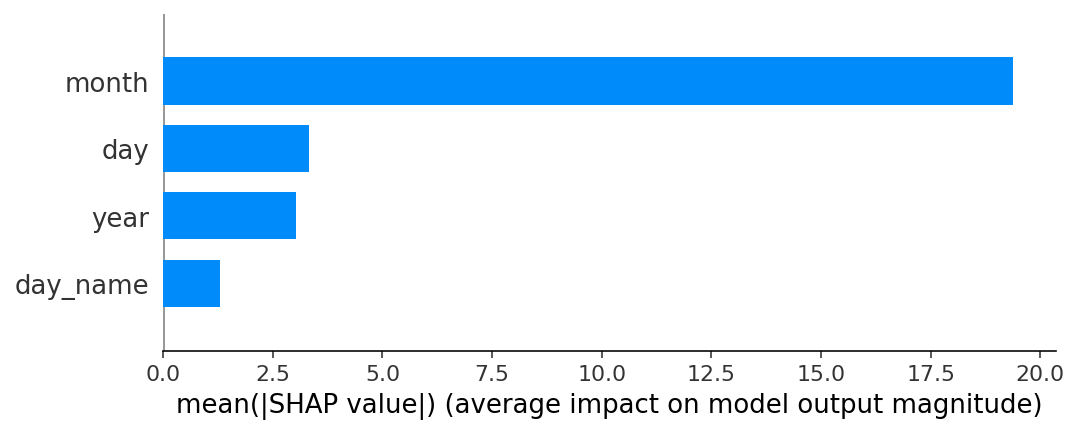

In [38]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

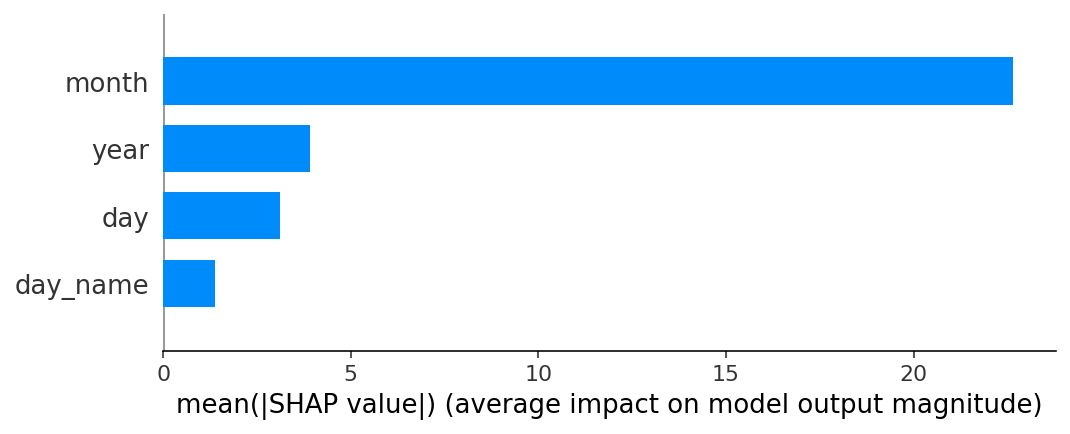

In [39]:
shap.summary_plot(shap_values_test, X_test, plot_type="bar")

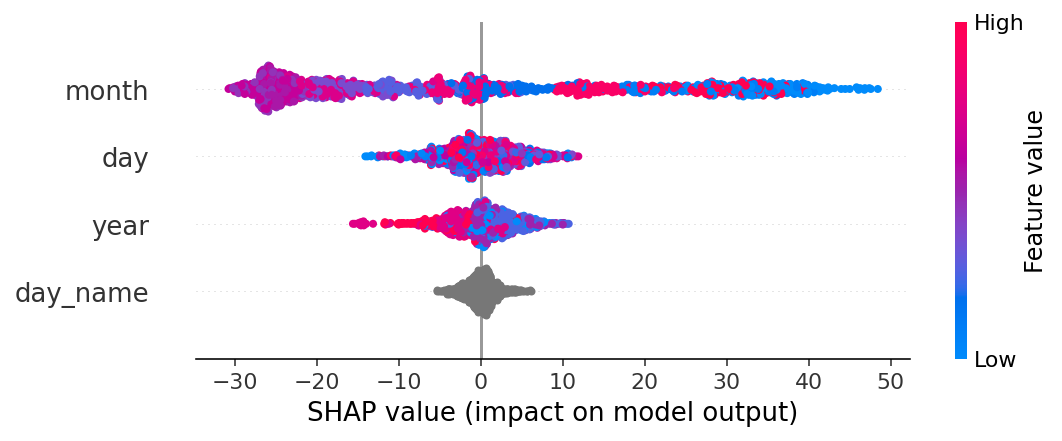

In [47]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

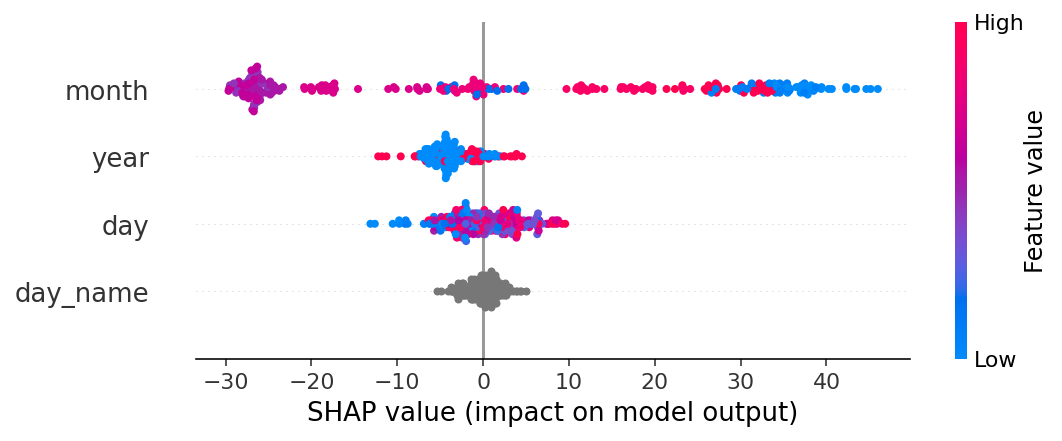

In [48]:
# summarize the effects of all the features
shap.summary_plot(shap_values_test, X_test)

In [40]:
dshap.iloc[[0]] 

,year,month,day,day_name
0,0.433135,-21.186345,-3.200536,-0.930889


In [41]:
dshap.iloc[0][dshap.iloc[0].values > 0].sort_values() #.sum()

year    0.433135
Name: 0, dtype: float64

In [42]:
dshap.iloc[0][dshap.iloc[0].values < 0].sort_values() #.sum()

month      -21.186345
day         -3.200536
day_name    -0.930889
Name: 0, dtype: float64

In [43]:
def individual_case_plot(explainer, X, case_index):
    """
    >>> individual_case_plot(explainer, X_train, 1)
    """
    shap_values = explainer.shap_values(X)
    g=shap.force_plot(explainer.expected_value, shap_values[case_index], X.iloc[case_index, :])
    print('SHAP values')
    dshap=pd.DataFrame(shap_values, columns=feature_cols)
    dpos=dshap.iloc[case_index][dshap.iloc[case_index].values > 0].sort_values(ascending=False)
    dneg=dshap.iloc[case_index][dshap.iloc[case_index].values < 0].sort_values(ascending=False)
    print(dpos)
    print(f'sum pos = {dpos.sum()}')
    print(dneg)
    print(f'sum neg = {dneg.sum()}')

    print(dpos.sum()+dneg.sum())
    print(dpos.sum()+np.abs(dneg.sum()))
    return g

In [44]:
individual_case_plot(explainer, X, 0)

SHAP values
year    0.433135
Name: 0, dtype: float64
sum pos = 0.4331354459122425
day_name    -0.930889
day         -3.200536
month      -21.186345
Name: 0, dtype: float64
sum neg = -25.31776985853446
-24.88463441262222
25.750905304446704


In [45]:
individual_case_plot(explainer, X, 120)

SHAP values
month    12.147512
Name: 120, dtype: float64
sum pos = 12.147511688387036
year        -1.253908
day_name    -1.337263
day        -10.174384
Name: 120, dtype: float64
sum neg = -12.765555431865465
-0.6180437434784292
24.9130671202525


In [46]:
shap.force_plot(explainer.expected_value, shap_values[:], X_train[:])